# Calculate and save HCW and tracer mass on shelf 

It has the same content as the script but I couldn't run ir remotely because of the netcdf library load.

In [1]:
# Calculate and save HCW and tracer mass on shelf
from netCDF4 import Dataset
import numpy as np
import pandas as pd

import canyon_tools.metrics_tools as mtt 
import canyon_tools.readout_tools as rout

In [2]:
# -------------------------------------------------------------------------------------------------------------------------
def Tracer_AlongShelf(Tr,TrAdv,MaskC,rA,hFacC,drF,yin,zfin,xi,yi,nzlim):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, size 19x90x360x360
    TrAdv : Array with concentration values for low diffusivity tracer. Until this function is more general, size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    TrMass =  Array with the mass of tracer over the shelf in HCW [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
    -----------------------------------------------------------------------------------------------------------------------
    '''
    maskExp = mtt.maskExpand(MaskC,TrAdv)

    TrMask=np.ma.array(TrAdv,mask=maskExp)   
    Tr1Mask=np.ma.array(Tr,mask=maskExp)   
    
    trlim1 = TrMask[0,nzlim,yi,xi]
    trlim2 = TrMask[0,nzlim+1,yi,xi]

    #trlim = (trlim1+trlim2)/2.0
    trlim = (trlim1)

    print('tracer limit concentration is: ',trlim)
    print(trlim1,trlim2)

    # mask cells with tracer concentration < trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
    HighConc_Mask = HighConc_Masked.mask

    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[yin:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)

    ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
   
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    TrConc_HCW = np.ma.masked_array(Tr[:,:zfin,yin:,:],mask = HighConc_Mask) 

    MassTrHighConc =np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol*TrConc_HCW,axis = 1),axis=1),axis=1)

    #Get total mass of tracer on shelf
    Total_Tracer = np.ma.sum(np.ma.sum(np.ma.sum(ShelfVolume_exp*Tr1Mask[:,:zfin,yin:,:],axis = 1),axis=1),axis=1)
    
    return (MassTrHighConc, Total_Tracer)

In [3]:
# Load grid files
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

bathyNoC = rout.getField(CanyonGridNoC, 'Depth')
hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']
drF = CanyonGridOut.variables['drF']
time = CanyonStateOut.variables['T']

In [4]:
# Load records for each run
import os
import sys
lib_path = os.path.abspath('Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records_extShelf 
import nocanyon_records_extShelf

In [6]:
records = canyon_records_extShelf.main()
recordsNoC = nocanyon_records_extShelf.main()

In [7]:
ii=0
for rec in records:
    print(ii,rec.name)
    ii=ii+1


0 CNTDIFF_run38
1 CNTDIFF_run37


In [10]:
records_sel = records
recordsNoC_sel = recordsNoC


In [11]:
# Calculate HCW and TR Mass
for record in records_sel:
    
    filename=('/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    Tr1 = rout.getField(filename,'Tr1') 
    Tr2 = rout.getField(filename,'Tr2') 
     
    TrMassHCW, TotTrMass = Tracer_AlongShelf(Tr1[:,:,:,0:],Tr2[:,:,:,0:], MaskCNoC, rA, hFacCNoC, drF[:], 227, 30,  180, 50,29)
    HCW = mtt.calc_HCW(Tr2[:,:,:,:], MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, yin=227, xin=0, xfin=719, zfin=30, xi=180, yi=50)

    TrMassHCWTr1, TotTrMassTr1 = Tracer_AlongShelf(Tr1[:,:,:,:],Tr1[:,:,:,:], MaskCNoC, rA, hFacCNoC, drF[:], 227, 30,  180, 50,29)
    HCWTr1 = mtt.calc_HCW(Tr1[:,:,:,:], MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, yin=227, xin=0, xfin=719, zfin=30, xi=180, yi=50)

    TrMassHCWTr2, TotTrMassTr2 = Tracer_AlongShelf(Tr2[:,:,:,:],Tr2[:,:,:,:], MaskCNoC, rA, hFacCNoC, drF[:], 227, 30,  180, 50,29)
       
    raw_data = {'time' : time,'HCW': HCW,'HCWTr1': HCWTr1,'TrMassHCW': TrMassHCW,'TotTrMass':TotTrMass,'TrMassHCWTr1': TrMassHCWTr1,
                'TotTrMassTr1':TotTrMassTr1,'TrMassHCWTr2': TrMassHCWTr2,'TotTrMassTr2':TotTrMassTr2}
    df = pd.DataFrame(raw_data, columns = ['time' ,'HCW','HCWTr1','TrMassHCW','TotTrMass',
                                           'TrMassHCWTr1','TotTrMassTr1','TrMassHCWTr2','TotTrMassTr2'])
    filename1 = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(record.exp_code,record.exp_code,record.run_num))
    df.to_csv(filename1)
    print(record.exp_code,record.run_num)

tracer limit concentration is:  7.21757
7.21757 7.39749
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
7.21757 7.39749
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
7.21757 7.39749
CNTDIFF_n run38
tracer limit concentration is:  7.21757
7.21757 7.39749
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
7.21757 7.39749
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
7.21757 7.39749
CNTDIFF_n run37


In [24]:
for record in recordsNoC_sel:
    
    filename=('/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc'  %(record.exp_code,record.run_num))
    Tr1 = rout.getField(filename,'Tr1') 
    Tr2 = rout.getField(filename,'Tr2') 
    print(filename) 
    TrMassHCWNoC, TotTrMassNoC = Tracer_AlongShelf(Tr1[:20,:,:,:],Tr2[:20,:,:,:], MaskCNoC, rA, hFacCNoC, drF[:], 227, 30,  180, 50,29)
    HCWNoC = mtt.calc_HCW(Tr2[:20,:,:,:], MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, yin=227, xin=0, xfin=719, zfin=30, xi=180, yi=50)

    TrMassHCWTr1, TotTrMassTr1 = Tracer_AlongShelf(Tr1[:20,:,:,:],Tr1[:20,:,:,:], MaskCNoC, rA, hFacCNoC, drF[:], 227, 30,  180, 50,29)
    HCWTr1 = mtt.calc_HCW(Tr1[:20,:,:,:], MaskCNoC, rA, hFacCNoC, drF[:],nzlim=29, yin=227, xin=0, xfin=719, zfin=30, xi=180, yi=50)

    TrMassHCWTr2, TotTrMassTr2 = Tracer_AlongShelf(Tr2[:20,:,:,:],Tr2[:20,:,:,:], MaskCNoC, rA, hFacCNoC, drF[:], 227, 30,  180, 50,29)
    
    raw_data = {'time' : time[0:19],'HCW': HCWNoC[0:19],'HCWTr1': HCWTr1[0:19],'TrMassHCW': TrMassHCWNoC[0:19],
                'TotTrMass':TotTrMassNoC[0:19],'TrMassHCWTr1': TrMassHCWTr1[0:19],
                'TotTrMassTr1':TotTrMassTr1[0:19],'TrMassHCWTr2': TrMassHCWTr2[0:19],
                'TotTrMassTr2':TotTrMassTr2[0:19]}
    df = pd.DataFrame(raw_data, columns = ['time' ,'HCW','HCWTr1','TrMassHCW','TotTrMass',
                                           'TrMassHCWTr1','TotTrMassTr1','TrMassHCWTr2','TotTrMassTr2'])
    
    filename1 = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(record.exp_code,record.exp_code,record.run_num))
    df.to_csv(filename1)
    print(filename1)
    print(record.exp_code,record.run_num)

/data/kramosmu/results/TracerExperiments/CNTDIFF_n/run42/ptracersGlob.nc
tracer limit concentration is:  7.21757
7.21757 7.39749
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
7.21757 7.39749
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
7.21757 7.39749
/data/kramosmu/results/TracerExperiments/CNTDIFF_n/HCW_TrMass_CNTDIFF_nrun42.csv
CNTDIFF_n run42
/data/kramosmu/results/TracerExperiments/CNTDIFF_n/run41/ptracersGlob.nc
tracer limit concentration is:  7.21757
7.21757 7.39749
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
7.21757 7.39749
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
7.21757 7.39749
/data/kramosmu/results/TracerExperiments/CNTDIFF_n/HCW_TrMass_CNTDIFF_nrun41.csv
CNTDIFF_n run41


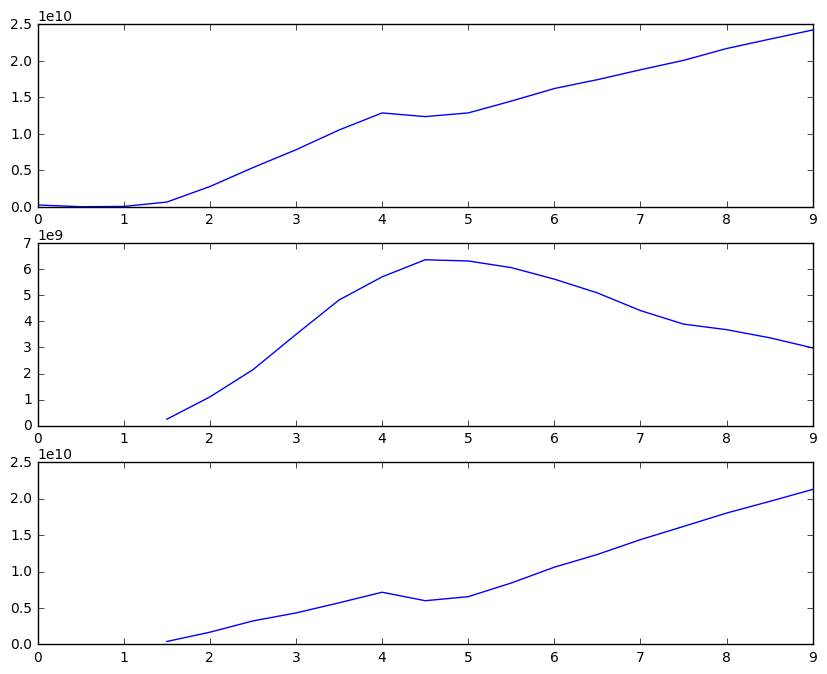

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(3,1,figsize=(10,8))

ax[0].plot(np.arange(19)/2,HCW[0:19])
ax[1].plot(np.arange(19)/2,HCWNoC[0:19])
ax[2].plot(np.arange(19)/2,HCW[0:19]-HCWNoC[0:19])

In [23]:
np.shape(HCWNoC[0:20])

#np.shape(range(20))

(19,)